In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:
# Carica il dataset relativo ai goal
data = pd.read_csv('../Data/worldcupallgoals.csv',encoding='latin1')
data.dropna()
# Carica il dataset relativo ai piazzamenti
df_wc = pd.read_csv('../Data/worldcups.csv')
df_wc.dropna()

# Funzione per formattare il nome
def format_name(row):
    name = row['given_name'] if row['given_name'].lower() != 'not applicable' else ''
    surname = row['family_name'] if row['family_name'].lower() != 'not applicable' else ''
    full_name = f"{name} {surname}".strip() #Concatena i nomi e rimuove spazi all'inizio e alla fine
    return full_name

time_ticks = [year for year in range(1930, 2023, 4) if year not in (1942, 1946)]
comparison_teams = ['Italy', 'Brazil', 'Germany']

## Top 5 players by goals scored

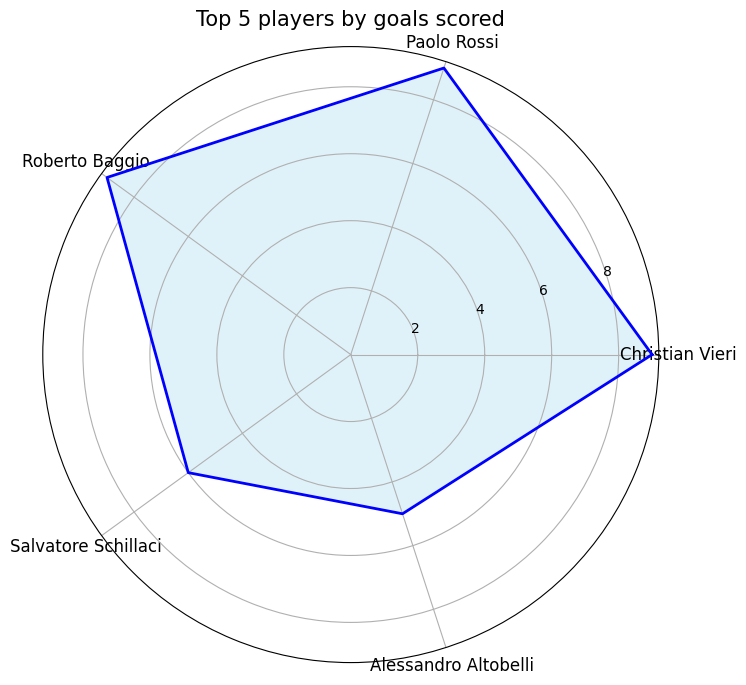

In [3]:
# Filtra i goal segnati da giocatori italiani
italy_goals = data[data['player_team_name'] == 'Italy'].copy()

# Crea il nome completo dei giocatori
italy_goals['full_name'] = italy_goals.apply(format_name, axis=1)

# Conta il numero totale di goal per ogni giocatore
gol_per_giocatore = italy_goals.groupby('full_name')['goal_id'].count().sort_values(ascending=False)

# Prendi i 5 migliori marcatori
top_giocatori = gol_per_giocatore.head(5)

# Prepara categorie e valori
categories = top_giocatori.index.tolist()
values = top_giocatori.values.tolist()

# Chiudi il radar (ripeti il primo valore alla fine)
values.append(values[0])
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles.append(angles[0])

# Crea il grafico
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Disegna il grafico
ax.fill(angles, values, color='skyblue', alpha=0.25)
ax.plot(angles, values, color='blue', linewidth=2)

# Etichette delle categorie
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)

# Cerchi e etichette radiali
num_circles = 4
max_value = max(values)
step = 2

for i in range(1, num_circles + 1):
    ax.text(np.pi / 2 + 5, i * step, str(i * step), ha='center', va='bottom', fontsize=10, color='black')

plt.title('Top 5 players by goals scored', fontsize=15)
plt.show()

## Italy's placement in each World Cup

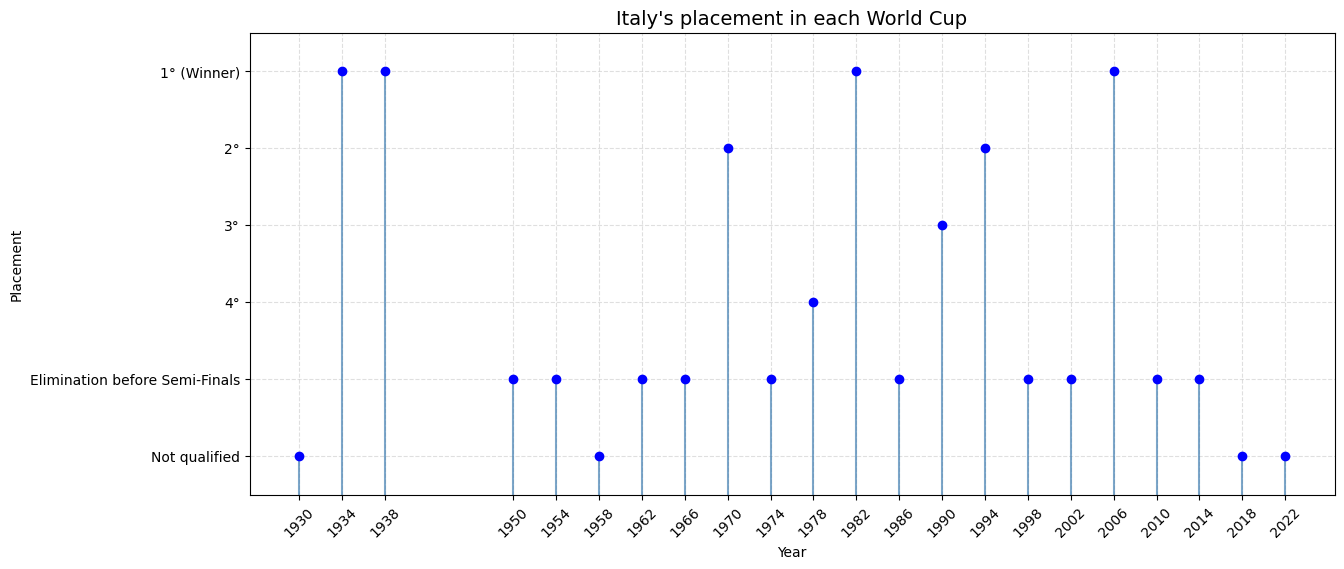

In [13]:
# Anni in cui l'Italia non si è qualificata (da inserire a mano)
non_qualificati = [1930, 1958, 2018, 2022]
def posizione_finale(row):
    year = row['year']
    if year in non_qualificati:
        return 6  # Non qualificata
    elif row['winner'] == 'Italy':
        return 1
    elif row['second'] == 'Italy':
        return 2
    elif row['third'] == 'Italy':
        return 3
    elif row['fourth'] == 'Italy':
        return 4
    else:
        return 5  # Eliminata prima semifinali

df_wc['italy_position'] = df_wc.apply(posizione_finale, axis=1)

# Creiamo la serie con anni come indice e posizioni come valori
posizioni = df_wc.set_index('year')['italy_position']

# Reindex con fill_value=6 (not qualified) per anni mancanti
posizioni_completa = posizioni.reindex(time_ticks, fill_value=6)

plt.figure(figsize=(14, 6))

posizioni_invertite = [7 - p for p in posizioni_completa]

plt.vlines(time_ticks, ymin=0, ymax=posizioni_invertite, color='steelblue', alpha=0.7)
plt.plot(time_ticks, posizioni_invertite, 'o', color='blue')

plt.ylim(0.5, 6.5)
plt.yticks(
    [1, 2, 3, 4, 5, 6],
    ["Not qualified", "Elimination before Semi-Finals", "4°", "3°", "2°", "1° (Winner)"]
)
plt.xticks(time_ticks, rotation=45)

plt.title("Italy's placement in each World Cup", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Placement")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


## Italy's World Cup Goals by 10-Minute Interval and Year

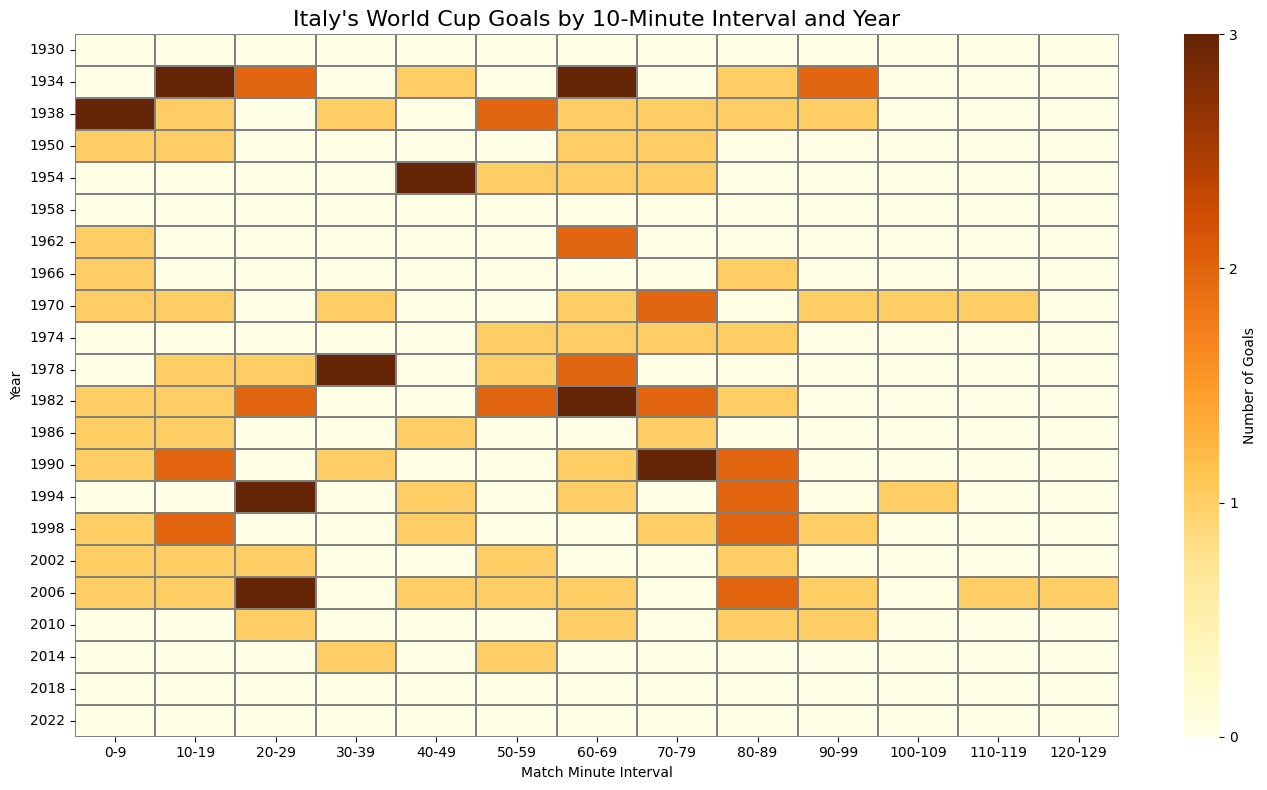

In [23]:
# Filtra i gol segnati dall’Italia
italia = data[data['player_team_name'] == 'Italy'].copy()

# Estrai l'anno dal nome del torneo nel subset Italia
italia['anno'] = italia['tournament_name'].str.extract(r'(\d{4})').astype(int)

# Assicurati che 'minute_regulation' sia numerico
italia['minute_regulation'] = pd.to_numeric(italia['minute_regulation'], errors='coerce')

# Rimuovi righe con minuti non validi
italia = italia.dropna(subset=['minute_regulation'])

# Crea la colonna con fasce di 10 minuti
italia['fascia_minuto'] = (italia['minute_regulation'] // 10 * 10).astype(int)

# Raggruppa per anno e fascia di minuto
heatmap_data = italia.groupby(['anno', 'fascia_minuto']).size().unstack(fill_value=0)

# Ordina le colonne
heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)

# Reindicizza per includere tutti gli anni (anche quelli senza gol)
heatmap_data = heatmap_data.reindex(time_ticks, fill_value=0)

# Etichette colonne più leggibili
heatmap_data.columns = [f"{x}-{x+9}" for x in heatmap_data.columns]

# Calcola il massimo numero di gol, per sapere fino a dove arrivare i tick
max_goals = int(heatmap_data.values.max())

# Crea la figura e l'asse
fig, ax = plt.subplots(figsize=(14, 8))

# Disegna la heatmap impostando in cbar_kws i tick interi
sns.heatmap(
    heatmap_data,
    cmap='YlOrBr',
    linewidths=0.3,
    linecolor='gray',
    ax=ax,
    cbar_kws={
        'label': 'Number of Goals',
        'ticks': np.arange(0, max_goals + 1, 1)  # step 1
    }
)

# Titoli ed etichette
ax.set_title("Italy's World Cup Goals by 10-Minute Interval and Year", fontsize=16)
ax.set_xlabel("Match Minute Interval")
ax.set_ylabel("Year")

plt.tight_layout()
plt.show()

## Goals Scored Over Time by Team

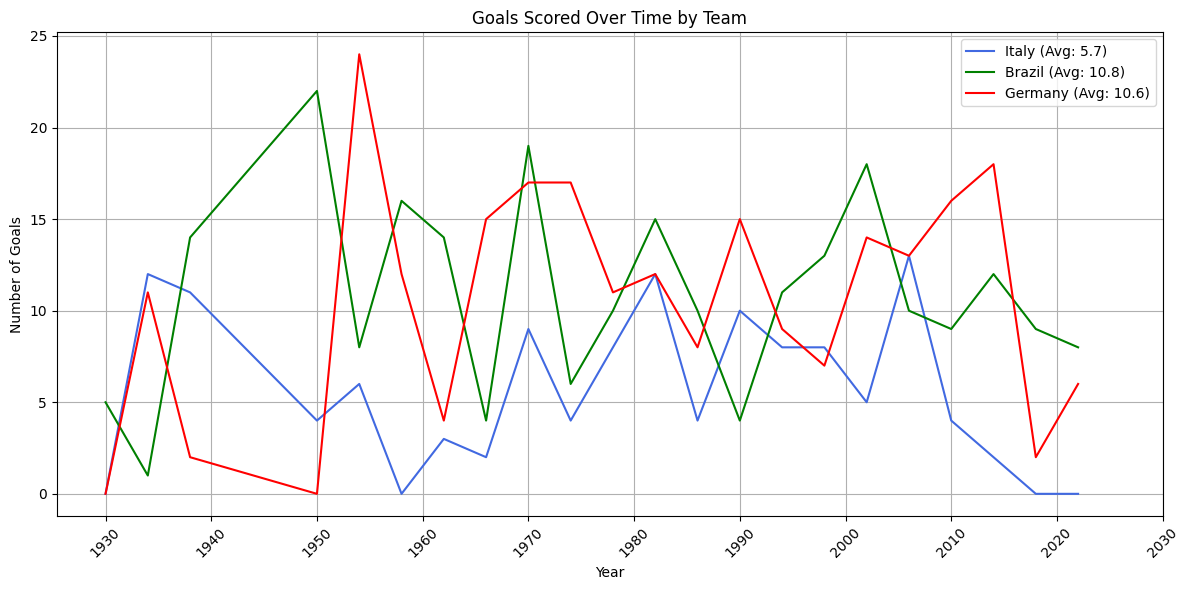

In [9]:
# Estrazione dell'anno dalla data della partita
data['year'] = pd.to_datetime(data['match_date']).dt.year
# Unifica i nomi della Germania
data['player_team_name'] = data['player_team_name'].replace({
    'West Germany': 'Germany',
    'East Germany': 'Germany'
})

comparison_teams_data = data[data['player_team_name'].isin(comparison_teams)]
# Conta i goal per anno e squadra
goals_per_year = comparison_teams_data.groupby(['year', 'player_team_name']).size().unstack(fill_value=0)

# Calcola le medie
averages = goals_per_year.mean()

# Colori personalizzati
custom_colors = {
    'Italy': 'royalblue',
    'Brazil': 'green',
    'Germany': 'red'
}

plt.figure(figsize=(12, 6))
for team in comparison_teams:
    plt.plot(goals_per_year.index, goals_per_year[team], label=f"{team} (Avg: {averages[team]:.1f})", color=custom_colors[team])
plt.title("Goals Scored Over Time by Team")
plt.xlabel("Year")
plt.xticks(range(1930,2040,10),rotation=45)
plt.ylabel("Number of Goals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()